## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import metrics

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import pickle

In [4]:
from lib_model_cluster import showTestCluster, showTestKMean

In [5]:
data_original = pd.read_csv("data_preprocessing/data_final.csv", index_col=0)
data_original.shape

(707, 11)

## Check Outlier

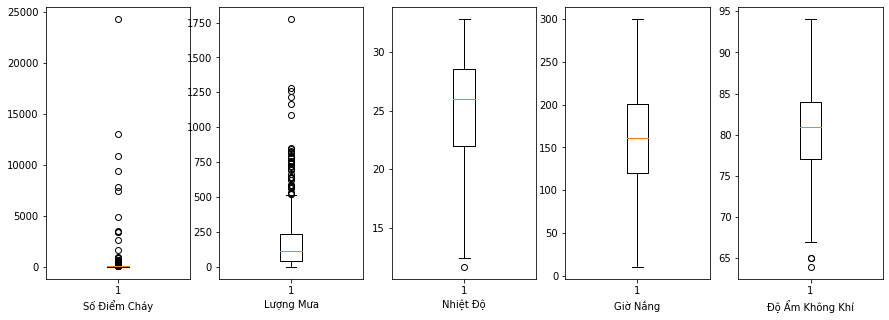

In [6]:
plt.figure(figsize=(15,5))
# ----------------
plt.subplot(1,5,1)
plt.boxplot(
    data_original.So_Diem_Chay
)
plt.xlabel('Số Điểm Cháy')
# ----------------
plt.subplot(1,5,2)
plt.boxplot(
    data_original.Rainfull
)
plt.xlabel('Lượng Mưa')
# ----------------
plt.subplot(1,5,3)
plt.boxplot(
    data_original.Air_Temperature
)
plt.xlabel('Nhiệt Độ')
# ----------------
plt.subplot(1,5,4)
plt.boxplot(
    data_original.Sunshine
)
plt.xlabel('Giờ Nắng')
# ----------------
plt.subplot(1,5,5)
plt.boxplot(
    data_original.Air_Humidity
)
plt.xlabel('Độ Ẩm Không Khí')
# ----------------
plt.show()

Cả 5 feature số điểm cháy, lượng mưa, nhiệt độ, độ ẫm không khí đều có outlier, vì vậy sẽ dùng RobustScaler để scale dữ liệu.

## Function

In [7]:
def checkComponentWSSE(data):
    scale = RobustScaler()
    data_scale = scale.fit_transform(data)
    length_columns = data.shape[1]
    dict_df = {}
    for col in range(0, length_columns):
        dict_df[col] = data_scale[: , col]
    df = pd.DataFrame(dict_df)
    for number in range(0, length_columns):
        columns = list(df.columns)
        col = columns.pop(number)
        df_sub = df[columns]
        showTestCluster(df_sub, 10, 'Remove: ' + data.columns[col])

In [8]:
def buildModel(data, k):
    preprocess = make_column_transformer(
        (RobustScaler(), data.columns),
    )
    pipeline = make_pipeline(
        preprocess,
        KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    )
    return pipeline.fit(data)

In [9]:
def showCorr(title, data_original):
    tuple_name = set(
        data_original.Name  
    )
    columns = [
        'Ten Tinh', 
        'So_Diem_Chay VS Sunshine', 
        'So_Diem_Chay VS Air_Humidity', 
        'So_Diem_Chay VS Air_Temperature', 
        'So_Diem_Chay VS Rainfull', 
    ]
    df_corr = pd.DataFrame(columns=columns)
    for name in tuple_name:
        df = data_original[data_original.Name == name]
        new_row = pd.Series(
            data = {
                columns[0]: name,
                columns[1]: df.So_Diem_Chay.corr(df.Sunshine),
                columns[2]: df.So_Diem_Chay.corr(df.Air_Humidity),
                columns[3]: df.So_Diem_Chay.corr(df.Air_Temperature),
                columns[4]: df.So_Diem_Chay.corr(df.Rainfull)
            }
        )
        df_corr = df_corr.append(new_row, ignore_index=True)
    df_corr_show = df_corr.set_index('Ten Tinh')
    plt.figure(figsize=(10, 2))
    sb.heatmap(
        df_corr_show.T,
        annot=True,
        vmax=1,
        vmin=-1,
        fmt='0.1f',
        cmap='coolwarm'
    )
    plt.title(title + ': Mối quan hệ giữa các chỉ số thời tiết với số Điểm cháy qua các tỉnh', fontweight='bold', fontsize=14)
    plt.show()

## Split By Year

In [10]:
df_group = data_original.groupby(['Name', 'Ma_Tinh']).mean().reset_index()
data_sub = df_group[['So_Diem_Chay','Sunshine','Air_Humidity','Air_Temperature','Rainfull']]

Vì khi phân tích số điểm cháy chúng ta đã thấy có sự tăng mạnh vào trước và sau năm 2017. Nên sẽ có 2 model cho trước và sau năm 2017.

## Build Model

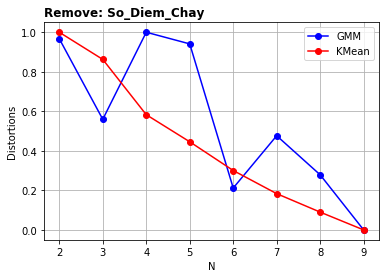

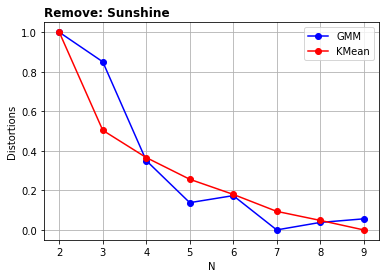

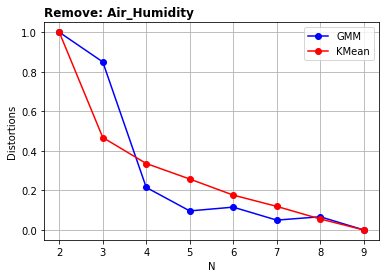

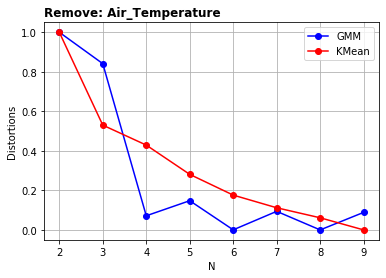

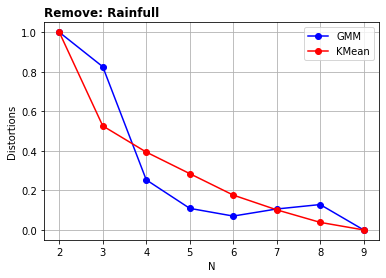

In [11]:
checkComponentWSSE(data_sub)

Từ những biểu đồ trên ta có thể thấy : 
<blockquote>
    - Model K-Mean chạy ỗn định hơn GMM trong trường hợp này. <br>
    - Feature 'Số Điểm cháy' có ảnh hưởng mạnh đến việc phân nhóm. <br>
    - Những feature còn lại sẽ có giá trị phân tích. <br>
    - Sẽ có 3 nhóm tối ưu trong trường hợp này.
</blockquote>

In [12]:
model = buildModel(data_sub, 3)
data_sub = data_sub.assign(
    Ma_Tinh = df_group.Ma_Tinh,
    Ten_Tinh = df_group.Name,
    Group = model.predict(data_sub)
)
data_sub

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,43.096154,175.973077,80.403846,28.119231,177.038462,96.0,Cà Mau,1
1,55.313131,169.140404,85.696970,25.755556,225.952525,46.0,Huế,1
2,20.414634,104.600000,75.000000,24.595122,118.704878,1.0,Hà Nội,1
3,452.123457,165.197531,81.160494,19.855556,180.830864,12.0,Lai Châu,0
4,8.295775,136.207042,81.507042,26.322535,187.852113,36.0,Nam Định,1
5,800.919540,175.241379,78.517241,21.175862,97.335632,14.0,Sơn La,2
6,57.746835,123.887342,81.189873,23.997468,130.622785,8.0,Tuyên Quang,1
7,28.828571,139.078571,81.042857,26.138571,223.917143,84.0,Vinh,1
8,45.982143,218.960714,77.464286,28.075000,109.085714,77.0,Vũng Tàu,1
9,19.042254,177.345070,79.690141,27.245070,278.729577,48.0,Đà Nẵng,1


In [13]:
display(
    data_sub[data_sub.Group == 0],
    data_sub[data_sub.Group == 1],
    data_sub[data_sub.Group == 2]
)

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
3,452.123457,165.197531,81.160494,19.855556,180.830864,12.0,Lai Châu,0


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,43.096154,175.973077,80.403846,28.119231,177.038462,96.0,Cà Mau,1
1,55.313131,169.140404,85.696970,25.755556,225.952525,46.0,Huế,1
2,20.414634,104.600000,75.000000,24.595122,118.704878,1.0,Hà Nội,1
4,8.295775,136.207042,81.507042,26.322535,187.852113,36.0,Nam Định,1
6,57.746835,123.887342,81.189873,23.997468,130.622785,8.0,Tuyên Quang,1
7,28.828571,139.078571,81.042857,26.138571,223.917143,84.0,Vinh,1
8,45.982143,218.960714,77.464286,28.075000,109.085714,77.0,Vũng Tàu,1
9,19.042254,177.345070,79.690141,27.245070,278.729577,48.0,Đà Nẵng,1


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
5,800.91954,175.241379,78.517241,21.175862,97.335632,14.0,Sơn La,2


Từ 3 bảng trên, có thể phân làm 3 nhóm với đặc tính như sau:
<blockquote>
    - Nhóm cháy cao (2) : gồm tỉnh Sơn La với số điểm cháy trung bình là hằng tháng là 1810.9 điểm. <br>
    - Nhóm cháy vừa (0) : gồm tỉnh Lai Châu với số điểm cháy trung bình là hằng tháng là 919.5 điểm.<br>
    - Nhóm cháy thấp (1) : gồm Cà Mau (68.34), Huế (142.33), Hà Nội (25.84), Nam Định (11.41), Tuyên Quang (113.25), Vinh(50), Vũng Tàu (80.87), Đà Nẵng (32.34)
</blockquote>
Có sự chuyển dịch của 2 tỉnh Hà Nội, Vũng Tàu từ nhóm nguy cơ 'cháy vừa' qua nhóm 'cháy thấp', với số điểm cháy cháy tăng lên.

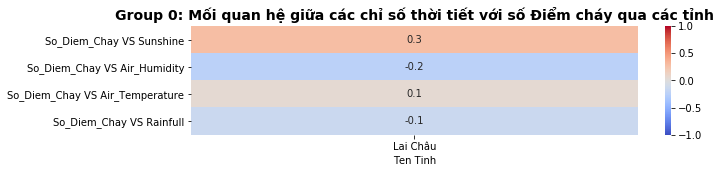

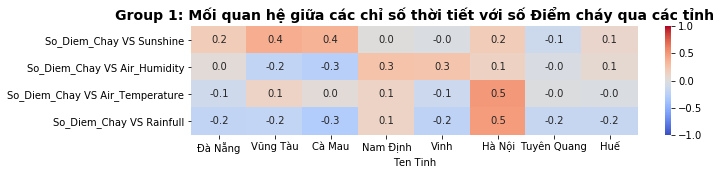

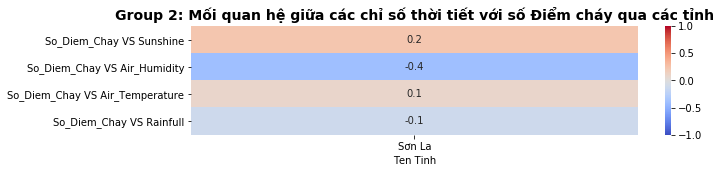

None

None

None

In [14]:
dict_group = {}
for index in range(0, data_sub.shape[0]):
    key = data_sub[['Ma_Tinh', 'Group']].iloc[index, 0]
    value = data_sub[['Ma_Tinh', 'Group']].iloc[index, 1]
    dict_group[key] = value
data_show = data_original.assign(
    Group = data_original.Ma_Tinh.map(lambda x: dict_group[x])
)
# ----------------
data_show.to_csv('data_model/data_cluster.csv')
# ----------------
display(
    showCorr('Group 0', data_show[data_show.Group == 0]),
    showCorr('Group 1', data_show[data_show.Group == 1]),
    showCorr('Group 2', data_show[data_show.Group == 2])
)

Từ hình trên có thể thấy, sau năm 2017, các chỉ số thời tiết có mối tương quan không đủ mạnh tới số điểm cháy của các tỉnh.

## Save Model Cluster

In [15]:
filename = 'save_model/model_cluster.sav'
pickle.dump(model, open(filename, 'wb'))

In [16]:
loaded_model = pickle.load(open(filename, 'rb'))

In [17]:
print(
    'Group',
    loaded_model.predict(
        data_sub.iloc[1, [0,1,2,3,4]].to_frame().T
    )[0]
)

Group 1
